In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sqlite3

%matplotlib inline

In [2]:
# Create a connection to the SQLite database
conn = sqlite3.connect('../Data/db/fraude_detection_warehouse_.db')

In [3]:
transactions = pd.read_sql('SELECT * FROM transactions', conn)
transactions.head()

,transaction_id,customer_id,device_id,transaction_date,transaction_type,amount,status,is_fraud,location
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,f66d0310-bf70-4552-a732-5950c93b1134,2020-02-12,depôt,9.385805e+06,réussie,1,Douala
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,f765ead3-ca24-48f4-9252-a6fd5fc53518,2022-02-03,depôt,3.358191e+06,réussie,0,Bafoussam
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,9cac18d3-defc-4142-9a39-b66fe1063f6e,2019-11-09,depôt,7.307758e+06,réussie,1,Bafoussam
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,2018-07-18,transfert,3.127519e+06,réussie,1,Bafoussam
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,2019-12-29,retrait,4.435274e+06,réussie,0,Yaoundé


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_id    100000 non-null  object 
 1   customer_id       100000 non-null  object 
 2   device_id         100000 non-null  object 
 3   transaction_date  100000 non-null  object 
 4   transaction_type  100000 non-null  object 
 5   amount            100000 non-null  float64
 6   status            100000 non-null  object 
 7   is_fraud          100000 non-null  int64  
 8   location          100000 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 6.9+ MB


In [5]:
transactions.describe(include="all")

,transaction_id,customer_id,device_id,transaction_date,transaction_type,amount,status,is_fraud,location
count,100000,100000,100000,100000,100000,1.000000e+05,100000,100000.000000,100000
unique,100000,10000,63259,2192,3,NaN,2,NaN,102
top,731b17cfadce442ab756b5b110a406c2,1968113994d547bd95b9a670c4bc9f13,548462e0-47f4-46c4-838a-9c7e7940968c,2019-03-28,depôt,NaN,réussie,NaN,Bamenda
freq,1,24,8,68,50048,NaN,89972,NaN,11350
mean,NaN,NaN,NaN,NaN,NaN,5.587385e+06,NaN,0.567070,NaN
std,NaN,NaN,NaN,NaN,NaN,3.514901e+06,NaN,0.495484,NaN
min,NaN,NaN,NaN,NaN,NaN,1.639254e+02,NaN,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,2.660834e+06,NaN,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,5.309755e+06,NaN,1.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,8.046252e+06,NaN,1.000000,NaN


changing date type

In [6]:
transactions.transaction_date = pd.to_datetime(transactions.transaction_date)
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    100000 non-null  object        
 1   customer_id       100000 non-null  object        
 2   device_id         100000 non-null  object        
 3   transaction_date  100000 non-null  datetime64[ns]
 4   transaction_type  100000 non-null  object        
 5   amount            100000 non-null  float64       
 6   status            100000 non-null  object        
 7   is_fraud          100000 non-null  int64         
 8   location          100000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 6.9+ MB


### transaction_type

In [7]:
list(transactions.transaction_type.value_counts())

[50048, 25056, 24896]

In [8]:
labels = list(transactions.transaction_type.unique())
sizes = list(transactions.transaction_type.value_counts())
colors = ['green', 'red', 'orange']
explode = (0.1, 0, 0)  # explode 1st slice

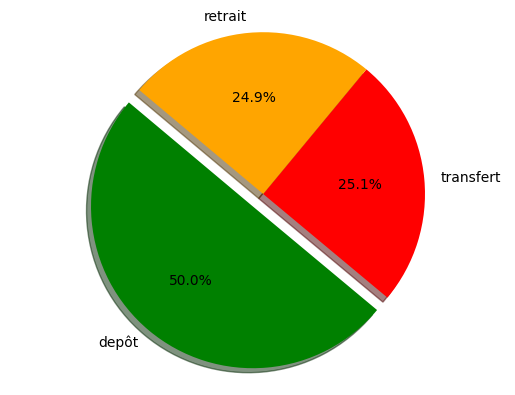

In [9]:
nbre_trans = transactions.transaction_type.value_counts()
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [10]:
transactions.transaction_type.value_counts().sort_values()

transaction_type
retrait      24896
transfert    25056
depôt        50048
Name: count, dtype: int64

In [11]:
length = transactions.shape[0]
# create dataframe percentage of transaction type
proportion = pd.DataFrame(transactions['transaction_type'].value_counts(normalize=True)*100)
proportion

,proportion
transaction_type,
depôt,50.048
transfert,25.056
retrait,24.896


### Répartition des types de transaction par localisation

In [12]:
localisation_repart = pd.crosstab(transactions["location"],transactions["transaction_type"])

In [13]:
localisation_repart = localisation_repart[(localisation_repart["depôt"] >= 800) | (localisation_repart["retrait"] >= 800) | (localisation_repart["transfert"] >= 800)]


<Axes: xlabel='location'>

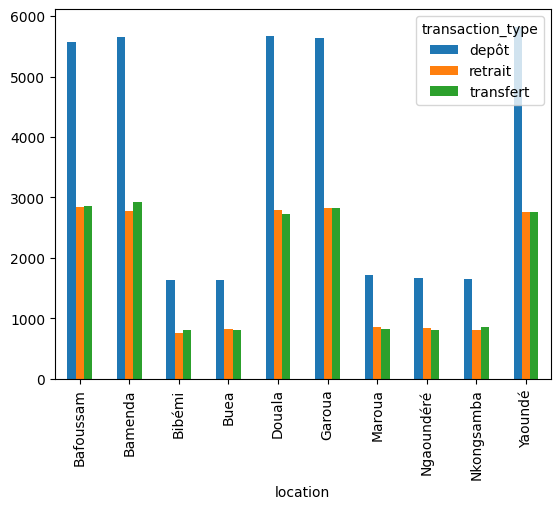

In [14]:
localisation_repart.plot.bar()

### Répartition des types de transaction sujet aux fraudes

In [15]:
localisation_fraud = pd.crosstab(transactions["transaction_type"],transactions["is_fraud"])

<Axes: xlabel='transaction_type'>

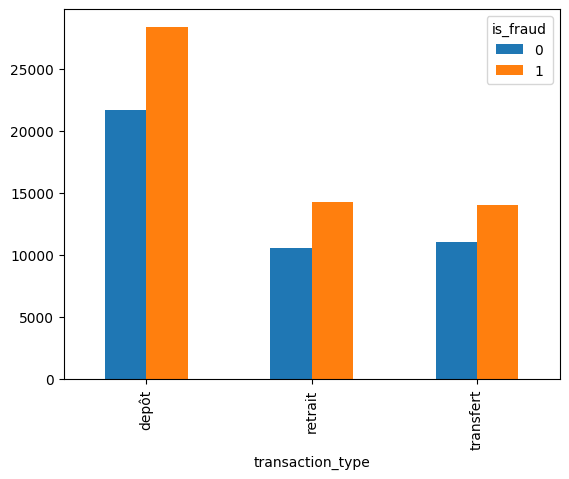

In [16]:
localisation_fraud.plot.bar()

### transaction amount

In [17]:
# transaction amount by transaction type
amount_mean = pd.DataFrame(transactions.groupby('transaction_type').amount.aggregate(['mean', 'median']))
amount_mean.head()

,mean,median
transaction_type,,
depôt,5.580478e+06,5.298153e+06
retrait,5.621055e+06,5.363998e+06
transfert,5.567728e+06,5.276008e+06


<Axes: xlabel='transaction_type'>

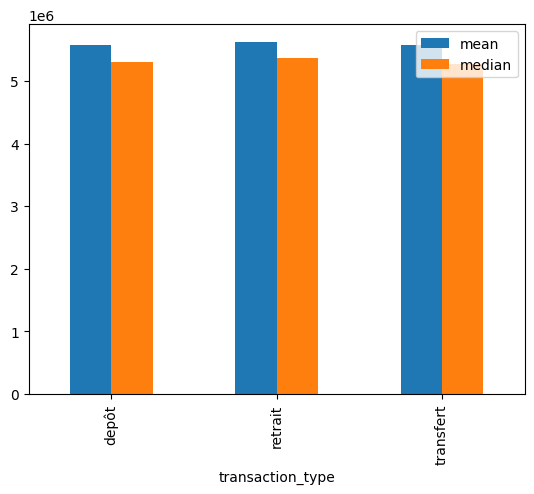

In [18]:
amount_mean.plot.bar()

In [19]:
transfert = transactions[transactions.transaction_type == 'transfert']
depot = transactions[transactions.transaction_type == 'depôt']
retrait = transactions[transactions.transaction_type == 'retrait']
type_list = [transfert, depot, retrait]


<Axes: xlabel='amount', ylabel='Count'>

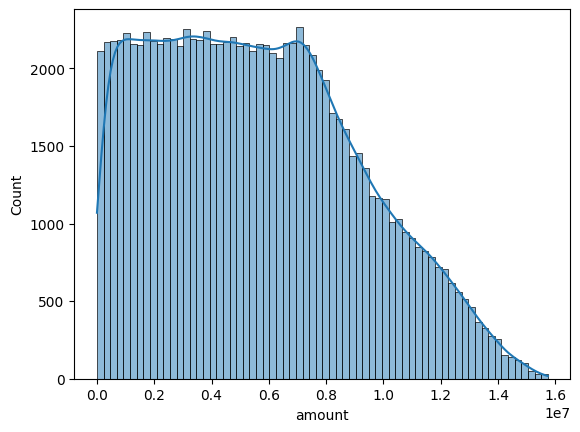

In [20]:
sns.histplot(transactions, x="amount", kde=True)

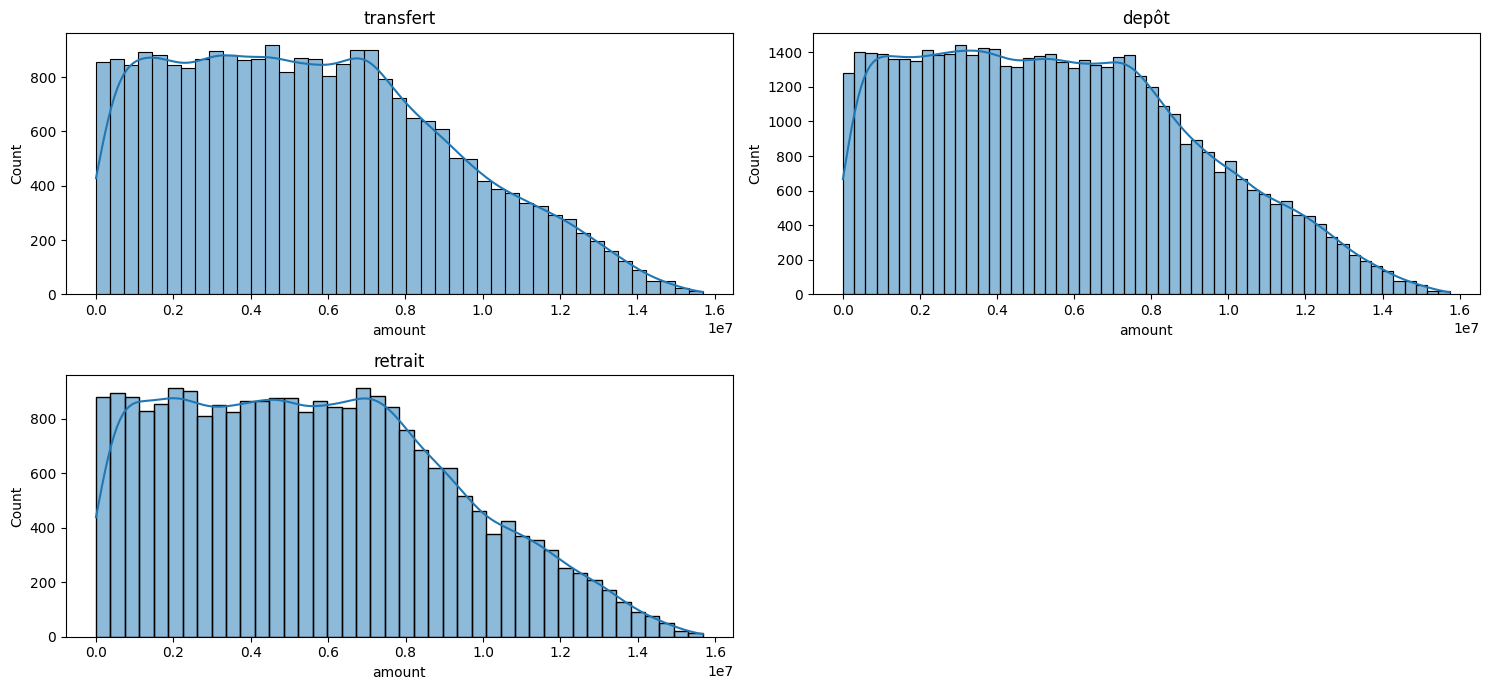

In [21]:
plt.figure(figsize=(15,7))
for i, value in enumerate(type_list, 1):
    plt.subplot(2,2,i)
    sns.histplot(value, x='amount', kde=True)
    plt.title(value.transaction_type.iloc[0])
    plt.tight_layout()
    plt.plot()

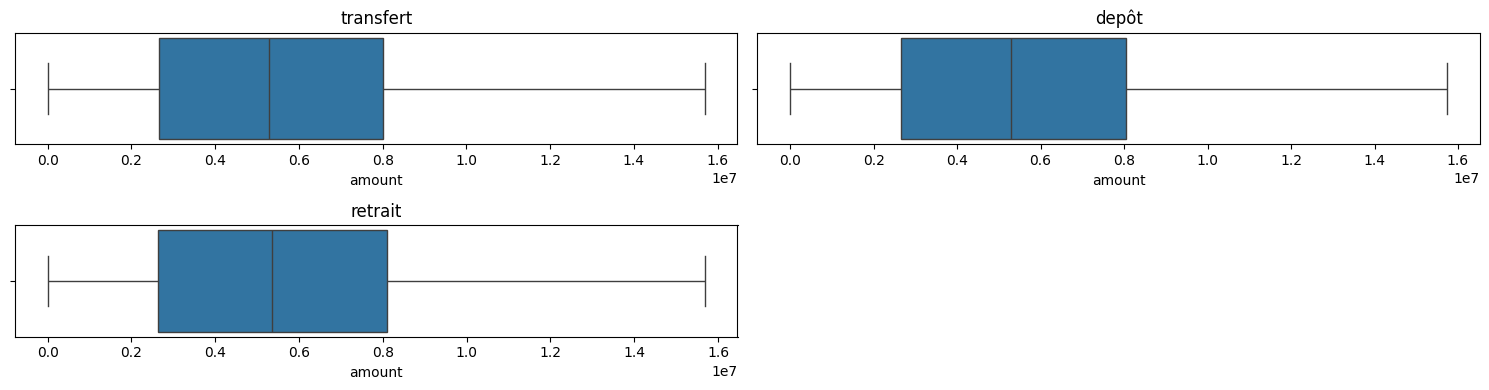

In [22]:
plt.figure(figsize=(15,4))
for i, value in enumerate(type_list, 1):
    plt.subplot(2,2,i)
    sns.boxplot(value, x='amount')
    plt.title(value.transaction_type.iloc[0])
    plt.tight_layout()
    plt.plot()

### Analyse temporelle

In [23]:
transactions['month'] = pd.to_datetime(transactions['transaction_date'].dt.strftime('%Y-%m'))
transactions['week'] = transactions['transaction_date'].dt.isocalendar().week
transactions['month_number'] = transactions['transaction_date'].dt.month
transactions['year'] = transactions['transaction_date'].dt.year

In [24]:
transactions_copy = transactions.set_index('transaction_date')
transactions_copy.head()

,transaction_id,customer_id,device_id,transaction_type,amount,status,is_fraud,location,month,week,month_number,year
transaction_date,,,,,,,,,,,,
2020-02-12,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,f66d0310-bf70-4552-a732-5950c93b1134,depôt,9.385805e+06,réussie,1,Douala,2020-02-01,7,2,2020
2022-02-03,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,f765ead3-ca24-48f4-9252-a6fd5fc53518,depôt,3.358191e+06,réussie,0,Bafoussam,2022-02-01,5,2,2022
2019-11-09,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,9cac18d3-defc-4142-9a39-b66fe1063f6e,depôt,7.307758e+06,réussie,1,Bafoussam,2019-11-01,45,11,2019
2018-07-18,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,transfert,3.127519e+06,réussie,1,Bafoussam,2018-07-01,29,7,2018
2019-12-29,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,retrait,4.435274e+06,réussie,0,Yaoundé,2019-12-01,52,12,2019


Montant de transaction par jour

In [25]:
transactions_per_day = pd.DataFrame(transactions_copy.groupby('transaction_date').amount.aggregate("mean")).reset_index()
fig = px.line(transactions_per_day, x='transaction_date', y='amount', title='transactions_per_day amount')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

Montant de transaction par mois

In [26]:
transactions_per_month = pd.DataFrame(transactions_copy.groupby("month").amount.aggregate('mean')).reset_index()
fig = px.line(transactions_per_month, x='month', y='amount', title='transactions_per_month amount')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

Montant de transaction par an

In [27]:
transactions_per_year = pd.DataFrame(transactions_copy.groupby("year").amount.aggregate('mean')).reset_index()
fig = px.line(transactions_per_year, x='year', y='amount', title='transactions_per_year amount')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

Nombre de transaction par jour

In [28]:
transactions_per_day_nbr = pd.DataFrame(transactions_copy.groupby("transaction_date").transaction_id.count()).reset_index()
fig = px.line(transactions_per_day_nbr, x='transaction_date', y='transaction_id', title='transactions_per_day_nbr')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

Nombre de transaction par mois

In [29]:
transactions_per_month_nbr = pd.DataFrame(transactions_copy.groupby("month").transaction_id.count()).reset_index()
fig = px.line(transactions_per_month_nbr, x='month', y='transaction_id', title='transactions_per_month_nbr').update_layout(xaxis_title="Date", yaxis_title="transactions")

fig.update_xaxes(rangeslider_visible=True)
fig.update_yaxes(rangemode='normal')
fig.show()

Nombre de transaction par an

In [30]:
transactions_per_month_nbr = pd.DataFrame(transactions_copy.groupby("year").transaction_id.count()).reset_index()
fig = px.line(transactions_per_month_nbr, x='year', y='transaction_id', title='transactions_per_month_nbr')

fig.update_xaxes(rangeslider_visible=True)

In [31]:
devices = pd.read_sql("SELECT * FROM devices", conn)
devices.head()

,device_id,device_type,os,manufacturer,model,last_used
0,31d420fd-2297-42c3-800c-0e997b9f2524,mobile,ios,Apple,iphone Xr,2021-02-25 19:16:08
1,37dc5ba9-c5bf-45b9-b122-ab13ca8b16cc,mobile,mac,SONY,Xperia 5 II,2022-01-29 04:11:27
2,66949cd2-042c-498a-8a50-175d581994ca,tablette,android,Sharp,aquos sense 5g,2020-08-15 00:34:29
3,0bcd3758-5ea7-4c6d-be42-83d527413899,tablette,mac,SONY,Xperia 5 II,2020-07-10 20:43:42
4,a4407a5b-0052-4e23-adc1-7360aafe1b47,mobile,android,dell,XPS 13,2020-03-09 14:37:24


In [32]:
# nbr de transaction par type d'appareil

transactions.head()


merge_device = pd.merge(transactions, devices, on='device_id')[["device_id", "device_type", "transaction_id", "amount"]]
merge_device.head()

,device_id,device_type,transaction_id,amount
0,f66d0310-bf70-4552-a732-5950c93b1134,tablette,731b17cfadce442ab756b5b110a406c2,9.385805e+06
1,f765ead3-ca24-48f4-9252-a6fd5fc53518,tablette,96f4ac611eaa4174b39149d98e569810,3.358191e+06
2,9cac18d3-defc-4142-9a39-b66fe1063f6e,mobile,1c11b97ba2994efbb6f85291e7062e00,7.307758e+06
3,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,tablette,99d146a3fbd04a38a5b83190b4ec22e3,3.127519e+06
4,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,mobile,bdab6a6430b44fadbf2f1682ccda4ae8,4.435274e+06


In [33]:
# with sql
merge_device_sql = pd.read_sql_query("""SELECT t.device_id, device_type, transaction_id, amount
                                     FROM transactions as t
                                     JOIN devices as d
                                     ON t.device_id = d.device_id
                                     """, conn)
merge_device_sql.head()

,device_id,device_type,transaction_id,amount
0,f66d0310-bf70-4552-a732-5950c93b1134,tablette,731b17cfadce442ab756b5b110a406c2,9.385805e+06
1,f765ead3-ca24-48f4-9252-a6fd5fc53518,tablette,96f4ac611eaa4174b39149d98e569810,3.358191e+06
2,9cac18d3-defc-4142-9a39-b66fe1063f6e,mobile,1c11b97ba2994efbb6f85291e7062e00,7.307758e+06
3,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,tablette,99d146a3fbd04a38a5b83190b4ec22e3,3.127519e+06
4,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,mobile,bdab6a6430b44fadbf2f1682ccda4ae8,4.435274e+06


In [34]:
merge_device.nunique()

device_id          63259
device_type            2
transaction_id    100000
amount            100000
dtype: int64

<Axes: xlabel='device_type'>

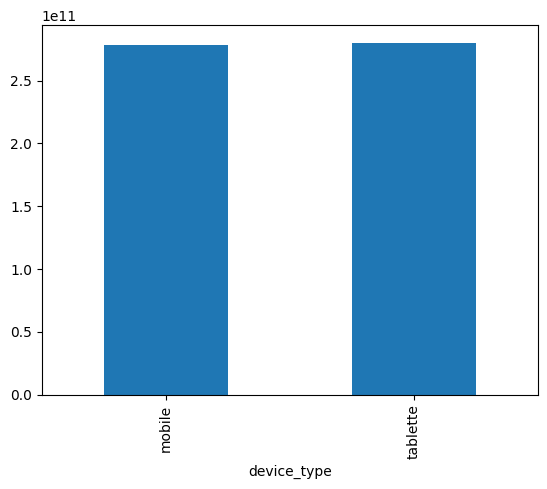

In [35]:
transaction_amount_per_device_type = merge_device.groupby('device_type').amount.aggregate("sum")
transaction_amount_per_device_type.plot.bar()

<Axes: xlabel='device_type'>

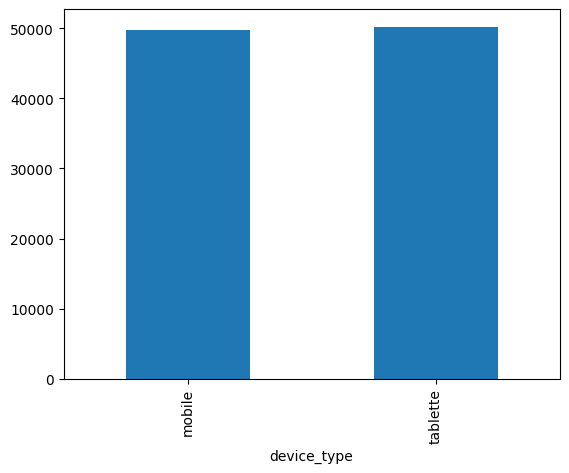

In [36]:
transaction_nbr_per_device_type = merge_device.groupby('device_type').transaction_id.count()
transaction_nbr_per_device_type.plot.bar()

In [37]:
# Répartition de transaction par territoire à partir d'un map

world_cities = pd.read_csv("../Data/worldcities.csv")[["city", "country"]]
world_cities.head()


,city,country
0,Tokyo,Japan
1,Jakarta,Indonesia
2,Delhi,India
3,Guangzhou,China
4,Mumbai,India


In [38]:
locations_out = world_cities[world_cities.country.isin(["Nigeria", "Gabon"])]

In [39]:
import geopandas as gpd

In [40]:
gdf = gpd.read_file("../Data/Afrique_Centrale.geojson")
gdf.rename(columns={"nom_pays": "country"}, inplace=True)
gdf.head()

,objectid,type_,desc_type,country,code_iso3,last_edited_date,geometry
0,1,1110100,Pays,Dem. Rep. of Congo,COD,2020-06-03 15:34:34+00:00,"MULTIPOLYGON (((20 -6.99905, 20.04293 -6.99868..."
1,2,1110100,Pays,Nigeria,NGA,2020-06-03 15:34:34+00:00,"MULTIPOLYGON (((5.52651 13.89201, 5.49465 13.8..."
2,3,1110100,Pays,Niger,NER,2020-06-03 15:34:34+00:00,"POLYGON ((0.50543 15, 0.5043 15, 0.4996 14.996..."
3,4,1110100,Pays,Gabon,GAB,2020-06-03 15:34:34+00:00,"MULTIPOLYGON (((11.69956 2.32216, 11.69521 2.3..."
4,5,1110100,Pays,Equatorial Guinea,GNQ,2020-06-03 15:34:34+00:00,"MULTIPOLYGON (((9.8286 2.33925, 9.82218 2.3469..."


<Axes: >

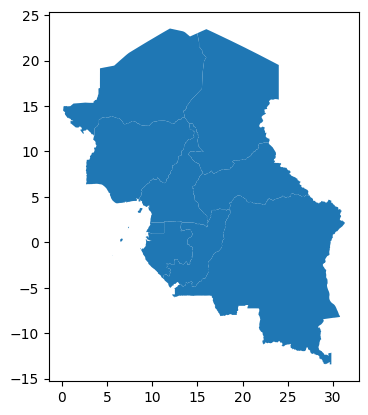

In [41]:
gdf.plot()

In [42]:
# nbre de transaction par client par jour / semaine / mois

In [43]:
locations_out

,city,country
19,Lagos,Nigeria
194,Abuja,Nigeria
213,Ibadan,Nigeria
382,Awka,Nigeria
400,Kano,Nigeria
...,...,...
47565,Bifoun,Gabon
47647,Gamba,Gabon
47684,Abakaliki,Nigeria
47685,Yenagoa,Nigeria


In [44]:
# nbre de transaction dans les villes hors du territoire
out_of_territory = transactions[transactions.location.isin(list(locations_out.city))]
out_of_territory.count()

transaction_id      4439
customer_id         4439
device_id           4439
transaction_date    4439
transaction_type    4439
amount              4439
status              4439
is_fraud            4439
location            4439
month               4439
week                4439
month_number        4439
year                4439
dtype: int64

In [45]:
# minimun / maximum 

### Analyse des historiques de transaction
Nombre moyen de transactions passées par client

In [46]:
transaction_history = pd.read_sql('SELECT * FROM transaction_history', conn)
transaction_history.head()

,history_id,customer_id,transaction_id,previous_balance,new_balance,transaction_date
0,1e9c3c0fc0b1496d8d2901d0f8f3531d,d159ae25b3d04387bbc006b8f0df4629,731b17cfadce442ab756b5b110a406c2,1.933918e+07,2.872498e+07,2020-02-12
1,d9970217233245029374bceecdc315c0,84d0894d1b9a4a8dbe13cfbb32d451df,96f4ac611eaa4174b39149d98e569810,9.557160e+06,1.291535e+07,2022-02-03
2,76fcc12cfc944467b6465cd0aba2893c,b01c160bdd134ac989f1d0d0163ac149,1c11b97ba2994efbb6f85291e7062e00,1.430163e+07,2.160939e+07,2019-11-09
3,3bb9c05095104929b845b85e2daa86e8,31bd9c0aa340439899f52de6d89ac6eb,99d146a3fbd04a38a5b83190b4ec22e3,7.646344e+06,4.518825e+06,2018-07-18
4,64f19595555c42c5ae3d1fb9eb17c793,ade32958209d40cfb475e5bef5a2b4a3,bdab6a6430b44fadbf2f1682ccda4ae8,9.679731e+06,5.244457e+06,2019-12-29


In [47]:
mean_trans_per_client = transaction_history.customer_id.value_counts().mean()
print(f"la moyenne de transaction par client est de {mean_trans_per_client}")

la moyenne de transaction par client est de 10.0
